## Plotting the gap

In [1]:
from quspin.operators import hamiltonian# operators
from quspin.basis import boson_basis_1d # Hilbert space boson basis
from quspin.basis import tensor_basis,spinless_fermion_basis_1d # Hilbert spaces
from quspin.basis import spin_basis_1d # Hilbert space spin basis
from quspin.tools.measurements import obs_vs_time # calculating dynamics
import numpy as np # general math functions
import matplotlib.pyplot as plt

In [2]:
from qutip import *
import numpy as np

In [3]:
def flip(s):
    if s == '+':
        return '-'
    elif s == '-':
        return '+'

def isodd(n):
    return int(n)%2 == True


def binom(n, k):
    return np.math.factorial(n) // np.math.factorial(k) // np.math.factorial(n - k)

def gaugeFixedBasis(Nsites,Nbosons):
    bosonStates = []
    gaugefixedStates = []
    # Let's first list out all possible boson occupations.
    # We can do this by looping through all numbers and putting it into base Nbosons
    for number in np.arange((Nbosons+1)**Nsites):
        bosonString = np.base_repr(number, base=Nbosons+1)
        bosonString = '0' * (Nsites - len(bosonString)) + bosonString

        # check total boson number
        if sum([int(c) for c in bosonString]) == Nbosons:
            bosonStates.append(bosonString)

    # Now loop through each state and insert appropriate qubit state which fixes the gauge condition to +1
    for state in bosonStates:
        gaugefixedstate = ''
        for site in np.arange(len(state)-1):
            thisn = state[site]
            gaugefixedstate += thisn
            if site == 0: # For the first site
                thislink = '-'*(isodd(thisn)) + '+'*(not isodd(thisn))
            else: # For all other sites
                if isodd(thisn):
                    thislink = flip(lastlink)
                else:
                    thislink = lastlink
            gaugefixedstate += thislink
            lastlink = thislink
        gaugefixedstate += state[-1]
        gaugefixedStates.append(gaugefixedstate)
    return gaugefixedStates

In [4]:
Nsites = 4
Nbosons = 4
basisStatesList = gaugeFixedBasis(Nsites,Nbosons) # binom(Nbosons+Nsites,Nbosons) states

In [5]:
# Now that we have the gauge fixed basis vectors, we could proceed in a few different ways. The harder
# thing would be to build the Hamiltonian and all operators explicitly in this basis. While probably
# more efficient for very large systems, we could also just build projectors that take us from
# the full Hilbert space down to the gauge fixed Hilbert space. Let's do that here in Qutip:

def siteState(c,Nbosons):
    return basis(Nbosons+1,int(c))

def linkState(c):
    if c == '+':
        return (basis(2,0) + basis(2,1)).unit()
    elif c == '-':
        return (basis(2,0) - basis(2,1)).unit()

# Build basis vectors in full Hilbert space
fullBasis = []
for state in basisStatesList: # Loop through each basis state
    basisVector = []
    for ind in np.arange(len(state)): # Loop through each site/link from left to right
        c = state[ind]
        if isodd(ind):
            basisVector.append(linkState(c))
        else:
            basisVector.append(siteState(c,Nbosons))
    # Now take tensor product to get the full basisVector
    fullBasis.append(tensor(basisVector))

# Now build projectors onto the gauge fixed Hilbert space
P_gaugefixed = 0
for i in np.arange(len(fullBasis)):
    P_gaugefixed += basis(len(fullBasis),i)*fullBasis[i].dag()

P = P_gaugefixed.full()

In [7]:
P.shape

(35, 5000)

In [11]:
Vvals=[50,100,200]
for Vi in range(len(Vvals)):
    V=Vvals[Vi]
    print("V ",V)
    min_sites=4
    max_sites=5
    set=[]
    for j in range(min_sites,max_sites):
        ###### parameters
        L_modes = j # system size
        L_spin = j
        total_boson_number = j
        cutoff = 5
        h = 1 # field strength
        t_min = 0.2 # hopping strength
        t_max = 4
        numberofvaluesof_t = 100
        tvals=np.linspace(t_min,t_max,numberofvaluesof_t)
        ###### create the basis
        # building the two bases to tensor together
        basis_spin = spin_basis_1d(L=L_spin)
        basis_boson=boson_basis_1d(L=L_modes)#,Nb=total_boson_number)
        basis = tensor_basis(basis_spin,basis_boson)
        print(basis.Ns)

        # Different system sizes and number of bosons - choose number of bosons to be equal to the system size

        gj=1
        deltas=np.zeros((2,len(tvals)))
        for i in range(len(tvals)):
            t=tvals[i]
            ##### create model
            hop=[[-t,i,i,i+1] for i in range(L_modes-1)]
            field = [[-h,i] for i in range(L_spin)]
            static=[["z|+-",hop],["z|-+",hop],["x|",field]]
            ###### setting up operators
            # set up hamiltonian dictionary and observable (imbalance I)
            no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
            H = hamiltonian(static,[],basis=basis,**no_checks)

            H1=H.todense()

            print(H1.shape)

            Hgaugefixed=np.dot(P,np.dot(H1,P.T.conj()))
            E,_=np.eigsh(Hgaugefixedk=2)
            # gap=E[1]-E[0]
            #
            # E, _ = H.eigsh(k=2)
            delta=np.abs(E[1]-E[0])
            deltas[0][i]=t
            deltas[1][i]=delta

        set.append(deltas)

    plt.title("Z2LGT Energy gap (1 boson per site) V="+str(V))
    for i in range(len(set)):
        plt.plot(set[i][0],set[i][1],".",label=str(i+min_sites)+" sites")
    plt.xlabel("Value of the hopping term (field h=1)")
    plt.ylabel("Energy gap")
    plt.legend()
    plt.show()

V  50


ValueError: expecting value for 'Nb','nb' or 'sps'

V  50


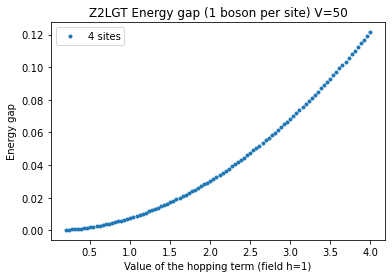

V  100


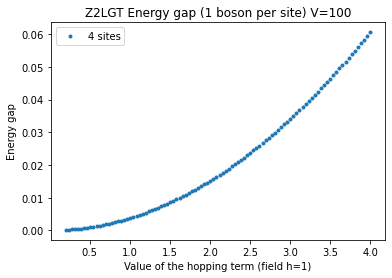

V  200


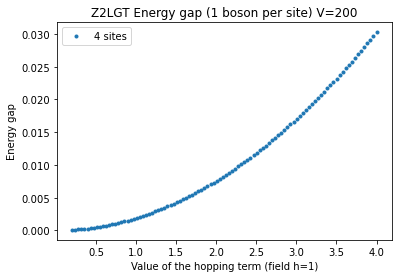

In [24]:
Vvals=[50,100,200]
for Vi in range(len(Vvals)):
    V=Vvals[Vi]
    print("V ",V)
    min_sites=4
    max_sites=5
    set=[]
    for j in range(min_sites,max_sites):
        ###### parameters
        L_modes = j # system size
        L_spin = j-1
        total_boson_number = j
        cutoff = 5
        h = 1 # field strength
        t_min = 0.2 # hopping strength
        t_max = 4
        numberofvaluesof_t = 100
        tvals=np.linspace(t_min,t_max,numberofvaluesof_t)
        ###### create the basis
        # building the two bases to tensor together
        basis_spin = spin_basis_1d(L=L_spin)
        basis_boson=boson_basis_1d(L=L_modes,sps=cutoff,Nb=total_boson_number)
        basis = tensor_basis(basis_spin,basis_boson)
        # print(basis)

        # Different system sizes and number of bosons - choose number of bosons to be equal to the system size

        gj=1
        deltas=np.zeros((2,len(tvals)))
        for i in range(len(tvals)):
            t=tvals[i]
            ##### create model
            hop=[[-t,i,i,i+1] for i in range(L_modes-1)]
            field = [[-h,i] for i in range(L_spin)]
            gausslawxxn=[[2*V,i,i+1,i] for i in range(L_spin-1)]
            gausslawxx=[[-2*gj*V,i,i+1] for i in range(L_spin-1)]
            gausslawnn=[[V,i,i] for i in range(L_modes)]
            gausslawn=[[-2*gj*V,i] for i in range(L_modes)]
            static=[["z|+-",hop],["z|-+",hop],["x|",field],["xx|n",gausslawxxn],["xx|",gausslawxx],["|nn",gausslawnn],["|n",gausslawn]]
            # gausslawxx=[[V,i,i+1] for i in range(L_spin-1)]
            # gausslawn=[[2*gj*V,i] for i in range(L_modes)]
            # static=[["z|+-",hop],["z|-+",hop],["x|",field],["xx|",gausslawxx],["|n",gausslawn]]
            ###### setting up operators
            # set up hamiltonian dictionary and observable (imbalance I)
            no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
            H = hamiltonian(static,[],basis=basis,**no_checks)
            E, _ = H.eigsh(k=2)
            delta=np.abs(E[1]-E[0])
            deltas[0][i]=t
            deltas[1][i]=delta

        set.append(deltas)

    plt.title("Z2LGT Energy gap (1 boson per site) V="+str(V))
    for i in range(len(set)):
        plt.plot(set[i][0],set[i][1],".",label=str(i+min_sites)+" sites")
    plt.xlabel("Value of the hopping term (field h=1)")
    plt.ylabel("Energy gap")
    plt.legend()
    plt.show()

set=[]
min_sites=3
max_sites=7
for j in range(min_sites,max_sites):
    ###### parameters
    L_modes = j # system size
    L_spin = j-1
    total_boson_number = 1
    cutoff = 3
    h = 1 # field strength
    t_min = 0 # hopping strength
    t_max = 4
    numberofvaluesof_t = 100
    tvals=np.linspace(t_min,t_max,numberofvaluesof_t)
    ###### create the basis
    # building the two bases to tensor together
    basis_spin = spin_basis_1d(L=L_spin)
    basis_boson=boson_basis_1d(L=L_modes,sps=cutoff,Nb=total_boson_number)
    basis = tensor_basis(basis_spin,basis_boson)
    # print(basis)

    # Different system sizes and number of bosons - choose number of bosons to be equal to the system size

    deltas=np.zeros((2,len(tvals)))
    for i in range(len(tvals)):
        t=tvals[i]
        ##### create model
        hop=[[-t,i,i,i+1] for i in range(L_modes-1)]
        field = [[-h,i] for i in range(L_spin)]
        static=[["z|+-",hop],["z|-+",hop],["x|",field]]
        ###### setting up operators
        # set up hamiltonian dictionary and observable (imbalance I)
        no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
        H = hamiltonian(static,[],basis=basis,**no_checks)
        E, _ = H.eigsh(k=2)
        delta=E[1]-E[0]
        deltas[0][i]=t
        deltas[1][i]=delta

    set.append(deltas)

plt.title("Z2LGT Energy gap (1 boson in total)")
for i in range(len(set)):
    plt.plot(set[i][0],set[i][1],".",label=str(i+min_sites)+" sites")
plt.xlabel("Value of the hopping term (field h=1)")
plt.ylabel("Energy gap")
plt.legend()

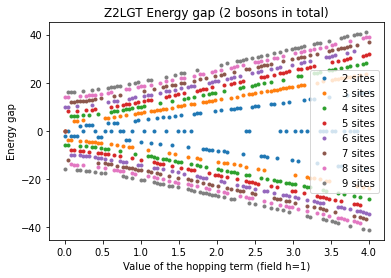

In [87]:
set=[]
min_sites=3
max_sites=10
for j in range(min_sites,max_sites):
    ###### parameters
    L_modes = j # system size
    L_spin = j-1
    total_boson_number = 2
    cutoff = 4
    h = 1 # field strength
    t_min = 0 # hopping strength
    t_max = 4
    numberofvaluesof_t = 100
    tvals=np.linspace(t_min,t_max,numberofvaluesof_t)
    ###### create the basis
    # building the two bases to tensor together
    basis_spin = spin_basis_1d(L=L_spin)
    basis_boson=boson_basis_1d(L=L_modes,sps=cutoff,Nb=total_boson_number)
    basis = tensor_basis(basis_spin,basis_boson)
    # print(basis)

    # Different system sizes and number of bosons - choose number of bosons to be equal to the system size

    deltas=np.zeros((2,len(tvals)))
    for i in range(len(tvals)):
        t=tvals[i]
        ##### create model
        hop=[[-t,i,i,i+1] for i in range(L_modes-1)]
        field = [[-h,i] for i in range(L_spin)]
        static=[["z|+-",hop],["z|-+",hop],["x|",field]]
        ###### setting up operators
        # set up hamiltonian dictionary and observable (imbalance I)
        no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
        H = hamiltonian(static,[],basis=basis,**no_checks)
        E, _ = H.eigsh(k=2)
        delta=E[1]-E[0]
        deltas[0][i]=t
        deltas[1][i]=delta

    set.append(deltas)

plt.title("Z2LGT Energy gap (2 bosons in total)")
for i in range(len(set)):
    plt.plot(set[i][0],set[i][1],".",label=str(i+min_sites)+" sites")
plt.xlabel("Value of the hopping term (field h=1)")
plt.ylabel("Energy gap")
plt.legend()

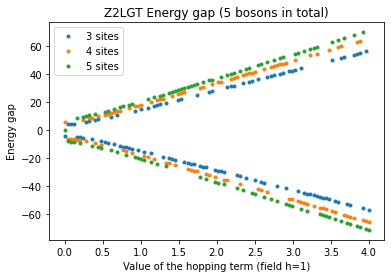

In [90]:
set=[]
min_sites=3
max_sites=6
for j in range(min_sites,max_sites):
    ###### parameters
    L_modes = j # system size
    L_spin = j-1
    total_boson_number = 5
    cutoff = 7
    h = 1 # field strength
    t_min = 0 # hopping strength
    t_max = 4
    numberofvaluesof_t = 100
    tvals=np.linspace(t_min,t_max,numberofvaluesof_t)
    ###### create the basis
    # building the two bases to tensor together
    basis_spin = spin_basis_1d(L=L_spin)
    basis_boson=boson_basis_1d(L=L_modes,sps=cutoff,Nb=total_boson_number)
    basis = tensor_basis(basis_spin,basis_boson)
    # print(basis)

    # Different system sizes and number of bosons - choose number of bosons to be equal to the system size

    deltas=np.zeros((2,len(tvals)))
    for i in range(len(tvals)):
        t=tvals[i]
        ##### create model
        hop=[[-t,i,i,i+1] for i in range(L_modes-1)]
        field = [[-h,i] for i in range(L_spin)]
        static=[["z|+-",hop],["z|-+",hop],["x|",field]]
        ###### setting up operators
        # set up hamiltonian dictionary and observable (imbalance I)
        no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
        H = hamiltonian(static,[],basis=basis,**no_checks)
        E, _ = H.eigsh(k=2)
        delta=E[1]-E[0]
        deltas[0][i]=t
        deltas[1][i]=delta

    set.append(deltas)

plt.title("Z2LGT Energy gap (5 bosons in total)")
for i in range(len(set)):
    plt.plot(set[i][0],set[i][1],".",label=str(i+min_sites)+" sites")
plt.xlabel("Value of the hopping term (field h=1)")
plt.ylabel("Energy gap")
plt.legend()

In [99]:
from __future__ import print_function, division
import sys,os
# line 4 and line 5 below are for development purposes and can be removed
qspin_path = os.path.join(os.getcwd(),"../../")
sys.path.insert(0,qspin_path)
########################################################################################
#                                   example 3                                          #
#    In this example we show how to use the photon_basis class to study spin chains    #
#    coupled to a single photon mode. To demonstrate this we simulate a single spin    #
#    and show how the semi-classical limit emerges in the limit that the number of     #
#    photons goes to infinity.                                                         #
########################################################################################
from quspin.basis import spin_basis_1d,photon_basis # Hilbert space bases
from quspin.operators import hamiltonian # Hamiltonian and observables
from quspin.tools.measurements import obs_vs_time # t_dep measurements
from quspin.tools.Floquet import Floquet,Floquet_t_vec # Floquet Hamiltonian
from quspin.basis.photon import coherent_state # HO coherent state
import numpy as np # generic math functions
#
##### define model parameters #####
Nph_tot=60 # maximum photon occupation
Nph=Nph_tot/2 # mean number of photons in initial coherent state
Omega=3.5 # drive frequency
A=0.8 # spin-photon coupling strength (drive amplitude)
Delta=1.0 # difference between atom energy levels
#
##### set up photon-atom Hamiltonian #####
# define operator site-coupling lists
ph_energy=[[Omega]] # photon energy
at_energy=[[Delta,0]] # atom energy
absorb=[[A/(2.0*np.sqrt(Nph)),0]] # absorption term
emit=[[A/(2.0*np.sqrt(Nph)),0]] # emission term
# define static and dynamics lists
static=[["|n",ph_energy],["x|-",absorb],["x|+",emit],["z|",at_energy]]
dynamic=[]
# compute atom-photon basis
basis=photon_basis(spin_basis_1d,L=1,Nph=Nph_tot)
# compute atom-photon Hamiltonian H
H=hamiltonian(static,dynamic,dtype=np.float64,basis=basis)
#
##### set up semi-classical Hamiltonian #####
# define operators
dipole_op=[[A,0]]
# define periodic drive and its parameters
def drive(t,Omega):
	return np.cos(Omega*t)
drive_args=[Omega]
# define semi-classical static and dynamic lists
static_sc=[["z",at_energy]]
dynamic_sc=[["x",dipole_op,drive,drive_args]]
# compute semi-classical basis
basis_sc=spin_basis_1d(L=1)
# compute semi-classical Hamiltonian H_{sc}(t)
H_sc=hamiltonian(static_sc,dynamic_sc,dtype=np.float64,basis=basis_sc)
#
##### define initial state #####
# define atom ground state
#psi_at_i=np.array([1.0,0.0]) # spin-down eigenstate of \sigma^z in QuSpin 0.2.3 or older
psi_at_i=np.array([0.0,1.0])  # spin-down eigenstate of \sigma^z in QuSpin 0.2.6 or newer
# define photon coherent state with mean photon number Nph
psi_ph_i=coherent_state(np.sqrt(Nph),Nph_tot+1)
# compute atom-photon initial state as a tensor product
psi_i=np.kron(psi_at_i,psi_ph_i)
#
##### calculate time evolution #####
# define time vector over 30 driving cycles with 100 points per period
t=Floquet_t_vec(Omega,30) # t.i = initial time, t.T = driving period
# evolve atom-photon state with Hamiltonian H
psi_t=H.evolve(psi_i,t.i,t.vals,iterate=True,rtol=1E-9,atol=1E-9)
# evolve atom GS with semi-classical Hamiltonian H_sc
psi_sc_t=H_sc.evolve(psi_at_i,t.i,t.vals,iterate=True,rtol=1E-9,atol=1E-9)
#
##### define observables #####
# define observables parameters
obs_args={"basis":basis,"check_herm":False,"check_symm":False}
obs_args_sc={"basis":basis_sc,"check_herm":False,"check_symm":False}
# in atom-photon Hilbert space
n=hamiltonian([["|n", [[1.0  ]] ]],[],dtype=np.float64,**obs_args)
sz=hamiltonian([["z|",[[1.0,0]] ]],[],dtype=np.float64,**obs_args)
sy=hamiltonian([["y|",	[[1.0,0]] ]],[],dtype=np.complex128,**obs_args)
# in the semi-classical Hilbert space
sz_sc=hamiltonian([["z",[[1.0,0]] ]],[],dtype=np.float64,**obs_args_sc)
sy_sc=hamiltonian([["y",[[1.0,0]] ]],[],dtype=np.complex128,**obs_args_sc)
#
##### calculate expectation values #####
# in atom-photon Hilbert space
Obs_t = obs_vs_time(psi_t,t.vals,{"n":n,"sz":sz,"sy":sy})
O_n, O_sz, O_sy = Obs_t["n"], Obs_t["sz"], Obs_t["sy"]
# in the semi-classical Hilbert space
Obs_sc_t = obs_vs_time(psi_sc_t,t.vals,{"sz_sc":sz_sc,"sy_sc":sy_sc})
O_sz_sc, O_sy_sc = Obs_sc_t["sz_sc"], Obs_sc_t["sy_sc"]
##### plot results #####
import matplotlib.pyplot as plt
import pylab
# define legend labels
str_n = "$\\langle n\\rangle,$"
str_z = "$\\langle\\sigma^z\\rangle,$"
str_x = "$\\langle\\sigma^x\\rangle,$"
str_z_sc = "$\\langle\\sigma^z\\rangle_\\mathrm{sc},$"
str_x_sc = "$\\langle\\sigma^x\\rangle_\\mathrm{sc}$"
# plot spin-photon data
fig = plt.figure()
plt.plot(t.vals/t.T,O_n/Nph,"k",linewidth=1,label=str_n)
plt.plot(t.vals/t.T,O_sz,"c",linewidth=1,label=str_z)
plt.plot(t.vals/t.T,O_sy,"tan",linewidth=1,label=str_x)
# plot semi-classical data
plt.plot(t.vals/t.T,O_sz_sc,"b.",marker=".",markersize=1.8,label=str_z_sc)
plt.plot(t.vals/t.T,O_sy_sc,"r.",marker=".",markersize=2.0,label=str_x_sc)
# label axes
plt.xlabel("$t/T$",fontsize=18)
# set y axis limits
plt.ylim([-1.1,1.4])
# display legend horizontally
plt.legend(loc="upper right",ncol=5,columnspacing=0.6,numpoints=4)
# update axis font size
plt.tick_params(labelsize=16)
# turn on grid
plt.grid(True)
# save figure
plt.tight_layout()
plt.savefig('example3.pdf', bbox_inches='tight')
# show plot
#plt.show()
plt.close()


Hermiticity check passed!
Hermiticity check passed!


/tmp/ipykernel_30355/1882167778.py:39: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.photon.photon_basis'>, to turn off this warning set check_symm=False in hamiltonian
  H=hamiltonian(static,dynamic,dtype=np.float64,basis=basis)
/tmp/ipykernel_30355/1882167778.py:39: UserWarning: Test for particle conservation not implemented for <class 'quspin.basis.photon.photon_basis'>, to turn off this warning set check_pcon=False in hamiltonian
  H=hamiltonian(static,dynamic,dtype=np.float64,basis=basis)
/tmp/ipykernel_30355/1882167778.py:54: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  H_sc=hamiltonian(static_sc,dynamic_sc,dtype=np.float64,basis=basis_sc)
/tmp/ipykernel_30355/1882167778.py:78: UserWarning: Test for particle conservation not implemented for <class 'quspin.basis.photon.photon_basis'>, to turn off this warning set check_pcon=False in